In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_csv('student-data.csv')

In [3]:
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,passed
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,no,4,3,4,1,1,3,6,no
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,no,5,3,3,1,1,3,4,no
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,no,4,3,2,2,3,3,10,yes
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,yes,3,2,2,1,1,5,2,yes
4,GP,F,16,U,GT3,T,3,3,other,other,...,no,no,4,3,2,1,2,5,4,yes


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 31 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

In [5]:

print('passed students:',len(df[df['passed'] == 'yes']))
print('failed students:',len(df[df['passed'] == 'no']))


passed students: 265
failed students: 130


In [6]:
#feature cols and target col
feature_cols = list(df.columns[:-1])
target_col = df.columns[-1]
X = df[feature_cols]
y = df[target_col]

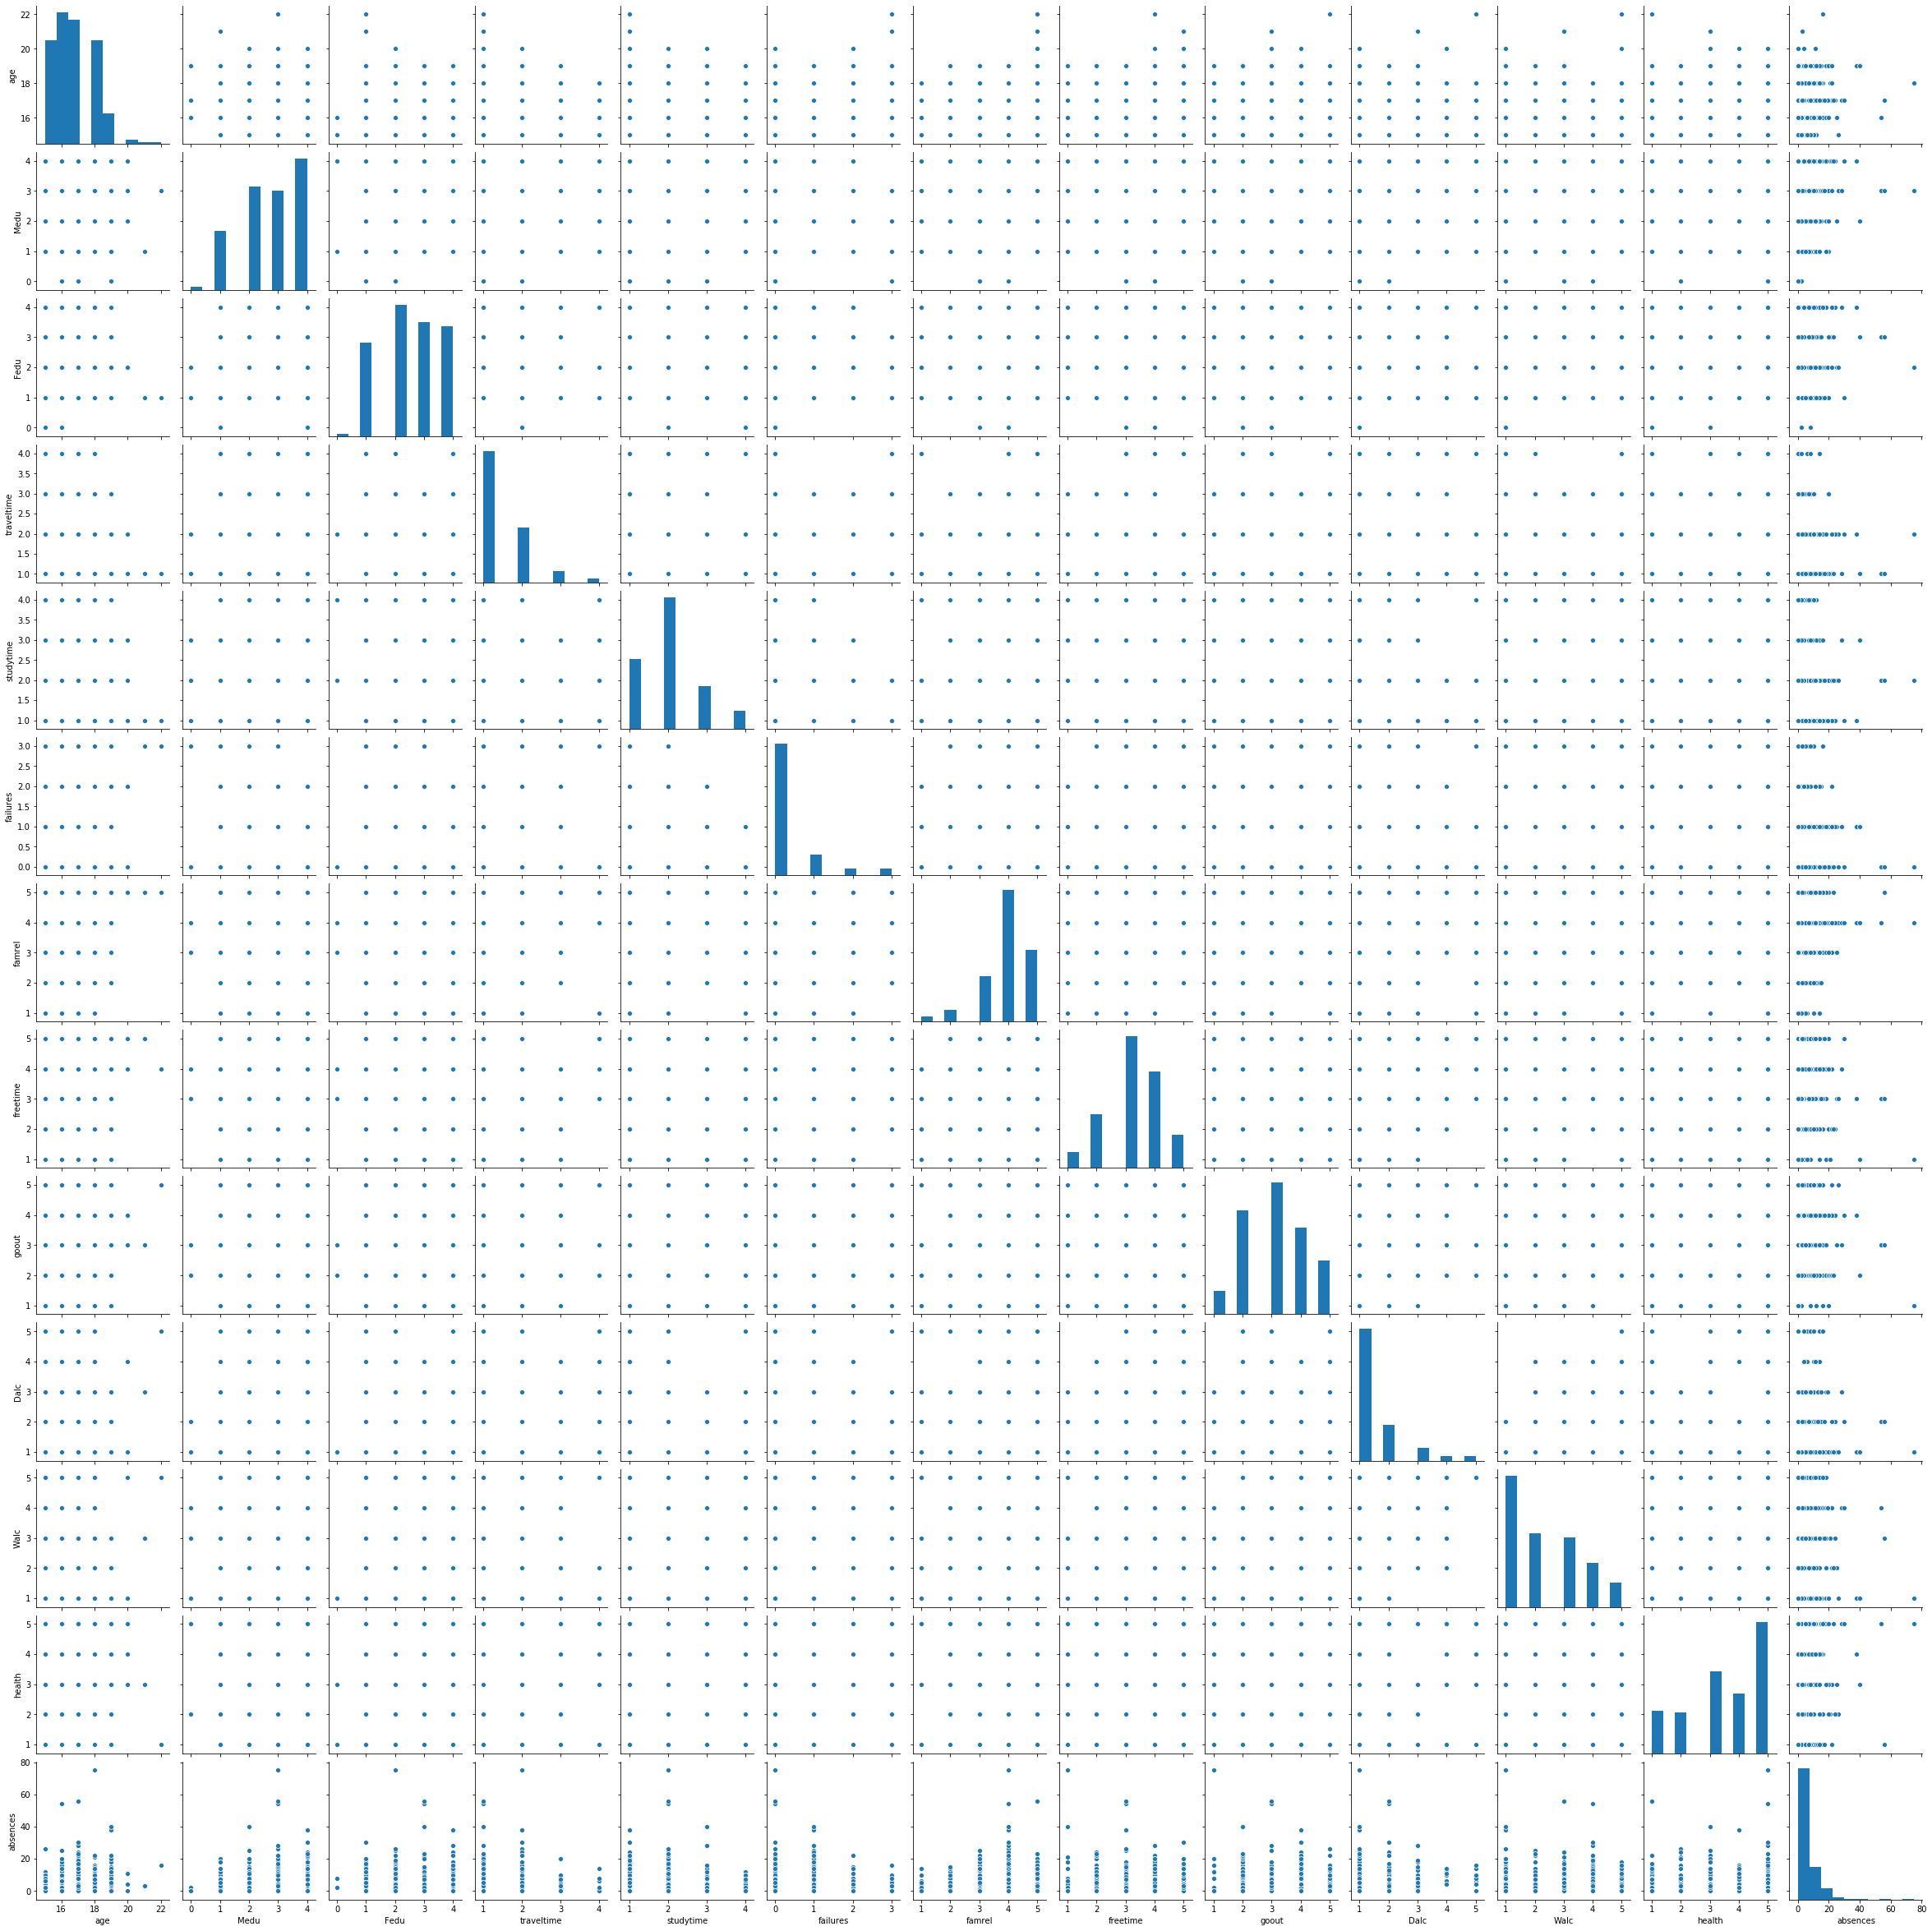

In [7]:
sns.pairplot(df)

### Preprocessing

In [8]:
def preprocess_features(X):
    output = pd.DataFrame(index=X.index)
    
    for col, col_data in X.iteritems():
        
        if col_data.dtype == 'object':
            col_data = col_data.replace(['yes','no'],[1,0])
        
        if col_data.dtype == 'object':
            col_data = pd.get_dummies(col_data, prefix= col)
        
        output = output.join(col_data)
    return output
X = preprocess_features(X)
print(X)
        

     school_GP  school_MS  sex_F  sex_M  age  address_R  address_U  \
0            1          0      1      0   18          0          1   
1            1          0      1      0   17          0          1   
2            1          0      1      0   15          0          1   
3            1          0      1      0   15          0          1   
4            1          0      1      0   16          0          1   
..         ...        ...    ...    ...  ...        ...        ...   
390          0          1      0      1   20          0          1   
391          0          1      0      1   17          0          1   
392          0          1      0      1   21          1          0   
393          0          1      0      1   18          1          0   
394          0          1      0      1   19          0          1   

     famsize_GT3  famsize_LE3  Pstatus_A  ...  higher  internet  romantic  \
0              1            0          1  ...       1         0         0   
1    

In [9]:
#train test split
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25)

In [10]:
def train_classifier(clf,X_train,y_train):
    start = time()
    clf.fit(X_train,y_train)
    end = time()
    tdiff = end -start
    print('time required {:.4f} sec'.format(tdiff))
    return tdiff

def predict_labels(clf,features,target):
    start = time()
    y_pred = clf.predict(features)
    end = time()
    tdiff = end - start
    print('time required for predictions is {:.4f} sec',format(tdiff))
    return f1_score(target.values,y_pred,pos_label='yes'), tdiff

def train_predict(clf,X_train,y_train,X_test,y_test):
    print ("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train)))
    train_time = train_classifier(clf,X_train,y_train)
    f1_train,prediction_time = predict_labels(clf,X_train,y_train)
    print("F1 score for training set: {:.4f}.".format(f1_train))
    f1_test, prediction_time_test = predict_labels(clf, X_test, y_test)
    print ("F1 score for test set: {:.4f}.".format(f1_test))
    return train_time,prediction_time_test,f1_train,f1_test 

In [11]:
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.utils import resample
from time import time
print("F1 score for predicting all \"yes\" on test set: {:.4f}".format(
    f1_score(y_test, ['yes']*len(y_test), pos_label='yes', average='binary')))
classifiers = [
    { 'name' : "GaussianNB", 'clf' : GaussianNB() },
    { 'name' : "Decision Tree", 'clf' : DecisionTreeClassifier(criterion="entropy",random_state=0) },
    { 'name' : "Support Vector Machines", 'clf' : SVC(random_state=0) },
]

training_sets = []
for train_size in range(100,300+1,100):
    X_res, y_res = resample(X_train,y_train,n_samples=train_size,random_state=0)
    training_sets.append ({ 'size' : train_size, 'X_train' : X_res, 'y_train' : y_res })

for clfData in classifiers:
    clfData['results'] = []
    for tset in training_sets:
        train_time,prediction_time_test,f1_train,f1_test = \
        train_predict(clfData['clf'], tset['X_train'], tset['y_train'], X_test, y_test)
        
        # Store our results
        clfData['results'].append({'train_time' : train_time, 'prediction_time_test' : prediction_time_test,
                                   'f1_train' : f1_train, 'f1_test' : f1_test, 'size' : tset['size']})
        
print ('----- MARKDOWN -----')
i = 0
for clfData in classifiers:
    i += 1
    print('** Classifer {} - {}**\n'.format(i,clfData['name']))
    print('| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |')
    print('| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |')
    for result in clfData['results']:
        print('| {} | {:.4f} | {:.4f} | {:.4f} | {:.4f} |'.format(result['size'], result['train_time'], 
                                                       result['prediction_time_test'],result['f1_train'],result['f1_test']))
    print('\n')

F1 score for predicting all "yes" on test set: 0.8353
Training a GaussianNB using a training set size of 100. . .
time required 0.0040 sec
time required for predictions is {:.4f} sec 0.0020036697387695312
F1 score for training set: 0.8613.
time required for predictions is {:.4f} sec 0.003032207489013672
F1 score for test set: 0.6769.
Training a GaussianNB using a training set size of 200. . .
time required 0.0050 sec
time required for predictions is {:.4f} sec 0.002001047134399414
F1 score for training set: 0.8143.
time required for predictions is {:.4f} sec 0.003004312515258789
F1 score for test set: 0.7015.
Training a GaussianNB using a training set size of 300. . .
time required 0.0040 sec
time required for predictions is {:.4f} sec 0.002996206283569336
F1 score for training set: 0.8050.
time required for predictions is {:.4f} sec 0.0019867420196533203
F1 score for test set: 0.7463.
Training a DecisionTreeClassifier using a training set size of 100. . .
time required 0.0050 sec
time

In [12]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from IPython.display import display
def f1_wrap(y_true, y_predict):
    return f1_score(y_true, y_predict, pos_label='yes')

parameters = {'C':range(1,6),'kernel':['linear','poly','rbf','sigmoid'],'degree':range(1,6)}

clf = SVC(random_state=0)

f1_scorer = make_scorer(f1_wrap)

grid_obj = GridSearchCV(clf, parameters, scoring=f1_scorer)
grid_obj = grid_obj.fit(X_train, y_train)
clf = grid_obj.best_estimator_

#df = pd.DataFrame(grid_obj.scorer_).sort_values('mean_validation_score').tail()
#display(df)
print("Parameters for the optimal model: {}".format(clf.get_params()))
# Report the final F1 score for training and testing after parameter tuning
print("Tuned model has a training F1 score of {}.".format(predict_labels(clf, X_train, y_train)[0]))
print("Tuned model has a testing F1 score of {}.".format(predict_labels(clf, X_test, y_test)[0]))


Parameters for the optimal model: {'C': 5, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': -1, 'probability': False, 'random_state': 0, 'shrinking': True, 'tol': 0.001, 'verbose': False}
time required for predictions is {:.4f} sec 0.007976531982421875
Tuned model has a training F1 score of 0.8590909090909091.
time required for predictions is {:.4f} sec 0.003998517990112305
Tuned model has a testing F1 score of 0.8176100628930818.
